# Numerical Simulation of the Simple Cake Eating Model
Bellman equation:
$$
v(x) = \max_{0\le c \le x} u(c) + \beta v(x^{\alpha} + (1 - \delta) x - c),\quad \alpha \in (0,1).
$$

## Value Function Iteration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.optimize import minimize_scalar, bisect

Step1: Define a function called 'maximize' to solve maximizer and maximum of any function

In [2]:
def maximize(g, lower_bound, upper_bound, *args):
	'''
	Input:  g: objective function
		    lower_bound: lower bound of the root
		    upper_bound: upper bound of the root
		    *args: other arguments for the objective function
	Output: maximizer and maximum of the objective function in the domain of [lower_bound, upper_bound]
		    x_max = res[0], y_max = res[1]
	'''
	objective = lambda x: -g(x, *args)
	result = minimize_scalar(objective, bounds = (lower_bound, upper_bound), method = 'bounded')
	maximizer, maximum = result.x, -result.fun
	return maximizer, maximum

Step2: Define a DGM class

In [3]:
class DGM:
	def __init__(self,
				 alpha = 0.33,
				 beta = 0.96,
				 gamma = 2,
				 delta = 0.07,
				 x_min = 0.1,
				 x_max = 10,
				 ngrid = 50):
		self.alpha = alpha
		self.beta = beta
		self.gamma = gamma
		self.delta = delta
		self.x_min = x_min
		self.x_max = x_max
		self.ngrid = ngrid

		self.xss = (self.alpha / (self.beta ** (-1) - (1 - self.delta))) ** (1 / (1 - self.alpha) )
		# self.x_min = 0.25 * self.xss
		# self.x_max = 2 * self.xss
		self.x_grid = np.linspace(self.x_min, self.x_max, self.ngrid)
	
	def utility(self, c):
		gamma = self.gamma
		if (c > 0) and (gamma == 1):
			return np.log(c)
		elif (c > 0) and (gamma != 1):
			return (c ** (1 - gamma))/(1 - gamma)
		else:
			return -np.infty

	def u_prime(self, c):
		return c ** (-self.gamma)
	
	def rhs(self, c, x, v): 
		'''
		Input:  c: consumption at date t
			    x: resourdgm at date t
			    v: value function at date t
		Output: u(c) + beta * v(x - c) a.k.a. the right-hand-side of bellman equation
		'''
		v_interp = interp1d(self.x_grid, v, kind = 'linear', fill_value = 'extrapolate') 
		# v_interp = UnivariateSpline(x_grid, v, ext = 'extrapolate')
		# length of x_grid and v should be equal
		x_prime = x ** self.alpha + (1 - self.delta) * x - c
		return self.utility(c) + self.beta * v_interp(x_prime)

Step3: Define the bellman operator and the function to iterate by value func

In [4]:
def bellman_operator(v, dgm):
	v_new = np.zeros_like(v)
	c_p = np.zeros_like(v)
	for i, xi in enumerate(dgm.x_grid):
		lower_bound = 1e-10 # minimal consumption constraint
		upper_bound = xi
		res = maximize(dgm.rhs, lower_bound, upper_bound, xi, v)
		c_p[i], v_new[i] = res[0], res[1]
	return c_p, v_new

def vfi(dgm,
		tol = 1e-6,
		max_iter = 1000,
		verbose = True,
		print_skip = 25):
	
	v = np.zeros_like(dgm.x_grid)
	i = 0
	error = 1
	
	while (i < max_iter) and (error > tol):
		result = bellman_operator(v, dgm)
		v_new = result[1]
		error = np.max(np.abs((v - v_new)/v_new))
		i += 1
		v = v_new
		
		if verbose and i % print_skip == 0:
			print(f"Error at iteration {i} is {error}")
		
	if error > tol:
		print("Failed to converge!")
	else:
		print(f"Converged in {i} iterations.")
	
	c_p = result[0]
	return c_p, v_new

In [5]:
dgm = DGM()
res = vfi(dgm)
c_p = res[0] # policy function
v = res[1] # value function

Error at iteration 25 is 0.031263179840197663
Error at iteration 50 is 0.007866104896287624
Error at iteration 75 is 0.0025395676339774118
Error at iteration 100 is 0.0008813838912800456
Error at iteration 125 is 0.0003134298246082148
Error at iteration 150 is 0.00011241885297374843
Error at iteration 175 is 4.044560865250412e-05
Error at iteration 200 is 1.456741985182069e-05
Error at iteration 225 is 5.248874809506499e-06
Error at iteration 250 is 1.8915322341638694e-06
Converged in 266 iterations.


## Visualize Results of Value Function Iteration

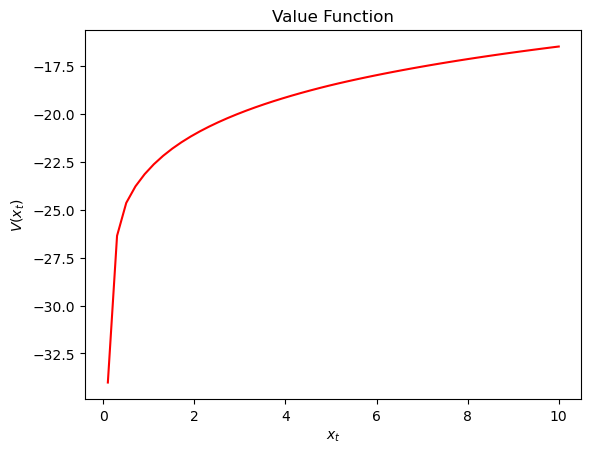

In [6]:
# fig1: Value Function
plt.plot(dgm.x_grid, v, 'r-')
plt.xlabel('$x_t$')
plt.ylabel('$V(x_t)$')
plt.title('Value Function')

plt.savefig('fig_01_value_function_python.png', dpi = 300)
plt.show()

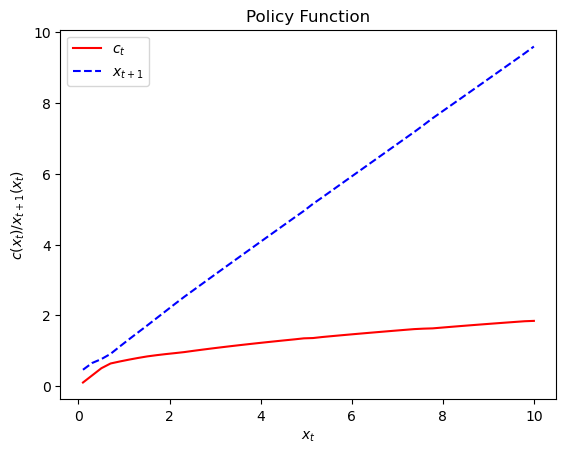

In [7]:
# fig2: Policy Function
plt.plot(dgm.x_grid, c_p, 'r-', label = '$c_t$')
plt.plot(dgm.x_grid, dgm.x_grid ** dgm.alpha + (1 - dgm.delta) * dgm.x_grid - c_p, 'b--', label = '$x_{t+1}$')
plt.xlabel('$x_t$')
plt.ylabel('$c(x_t)/x_{t+1}(x_t)$')
plt.legend(loc = 'best')
plt.title('Policy Function')

plt.savefig('fig_02_policy_function_python.png', dpi = 300)
plt.show()